# Exploring the Data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
closing_prices = pd.read_pickle("./data/stocks/closing_prices.pkl")

In [3]:
closing_prices.head()

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31 00:00:00-04:00,119.091064,54.044529,96.999535,140.715378,279.459991,94.968796,318.500000,236.614792,25.615273,63.578457,...,215.037827,578.000854,63.586994,63.053558,101.175644,116.083115,283.220001,112.488220,49.660881,149.774765
2022-11-01 00:00:00-04:00,118.627167,53.866943,97.362274,141.205582,277.067993,95.507393,316.019989,238.513962,25.791525,65.238472,...,217.984344,586.260132,67.527603,63.818604,104.247551,115.984947,238.300003,110.989700,49.345360,151.701843
2022-11-02 00:00:00-04:00,116.317108,52.979031,96.117180,138.908371,268.189056,93.813271,301.220001,232.444397,25.292147,65.121300,...,216.929901,577.634888,66.801170,63.247234,102.993103,115.219238,236.029999,106.871262,47.318386,146.377563
2022-11-03 00:00:00-04:00,116.307640,53.640030,94.558372,138.812241,252.862579,94.283310,285.929993,231.132614,25.644648,64.418236,...,214.791443,587.941711,66.154366,63.092289,105.857597,117.310219,227.320007,104.618507,46.008495,130.265701
2022-11-04 00:00:00-04:00,118.191650,55.228413,96.146599,139.638870,257.075592,93.215919,285.750000,231.876617,25.909025,65.599770,...,217.994202,587.189941,70.463142,63.479664,105.897102,119.548424,230.559998,104.052841,47.576530,132.778839


<AxesSubplot:xlabel='Date'>

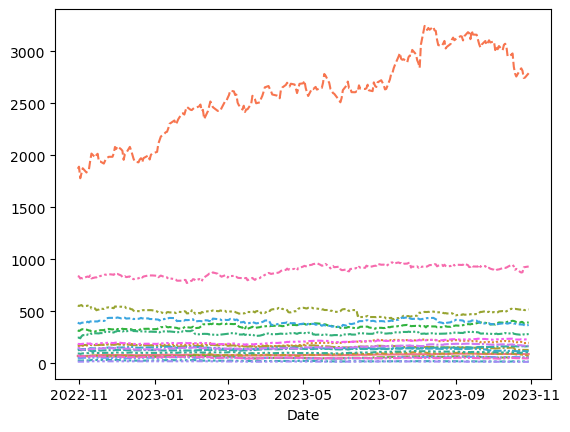

In [4]:
# plot some random stocks
sns.lineplot(data = closing_prices.sample(20, axis = 1), legend = None)

As we can see, the price distribution of stocks is not uniform, so when clustering them like this, we will not get things that are informative to identify their motions. Thus, we choose a way to normalize:
- L^2 normalization: divides each column by its L^2 norm
- Percent normalization: instead of keeping track of the change in price, keep track of the *percent change in price*
- Binary normalization: sign(percent normalization)
- Sharpe normalization: normalize by rate of return minus market rate, adjusted for variance.

In this notebook, we will use L^2 and Sharpe normalization

# L^2 normalization

<AxesSubplot:xlabel='Date'>

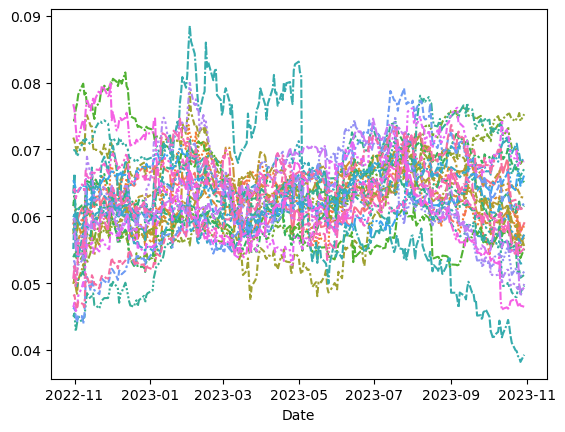

In [5]:
from data_processing.preprocessing import l2_normalization

closing_prices_l2 = l2_normalization(closing_prices)
sns.lineplot(data = closing_prices_l2.sample(30, axis = 1), legend = None)

We look at the correlation matrix of the closing price, and try to tease out when stocks are the same based on their correlation.

In [6]:
tickers = closing_prices_l2.columns
corr_l2 = np.tril(closing_prices_l2.corr().values, -1)
high_corrs_l2 = np.where((corr_l2 > 0).astype(int) == 1)
high_corrs_l2 = list(zip(high_corrs_l2[0], high_corrs_l2[1]))
high_corrs_l2.sort(key = lambda a: -corr_l2[a])
# print the top 10 high correlations
for i, j in high_corrs_l2[:10]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr_l2[i][j]}")

Correlation between GOOG and GOOGL is: 0.9998610165792761
Correlation between NWS and NWSA is: 0.9958647066427453
Correlation between LEN and DHI is: 0.988531602338576
Correlation between VMC and MLM is: 0.9865038326388126
Correlation between HBAN and CMA is: 0.985021355283432
Correlation between HBAN and FITB is: 0.9846009612328966
Correlation between FOX and FOXA is: 0.9837114526275602
Correlation between KEY and CFG is: 0.9827912987337264
Correlation between LRCX and AMAT is: 0.9827099056835811
Correlation between NVDA and AVGO is: 0.982395985001289


We notice a few things:
- Some stocks are listed twice, such as NSW and NWSA. Usually this is because one class of shares have voting power and one does not. We should keep these pairs in mind for later, as they can be used for benchmarking our clustering algorithms.
- While not seen in the above printout, it is interesting to note that some usual suspects are highly correlated, like GOOG (Google) and AMZN (Amazon) (correlation about 0.95, a bit further down). But some of the most highly-correlated tickers are things like ZION and KEY, which are both small regional banks (in Utah and Idaho respectively), or LEN and DHI, both home construction companies

<AxesSubplot:xlabel='Date'>

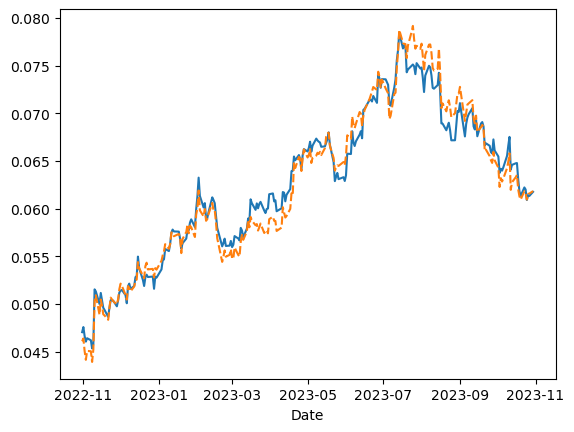

In [7]:
ax, fig = plt.subplots()
sns.lineplot(data = closing_prices_l2[["LEN", "DHI"]], legend = None)

We examine low correlations as well.

In [8]:
corr_l2 = closing_prices_l2.corr().values
low_corrs_l2 = np.where((corr_l2 < -0.8).astype(int) == 1)
low_corrs_l2 = list(zip(low_corrs_l2[0], low_corrs_l2[1]))
for i, j in low_corrs_l2[:10]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr_l2[i][j]}")

Correlation between MMM and ACGL is: -0.8072864443321407
Correlation between MMM and CDNS is: -0.8199487608486313
Correlation between MMM and GE is: -0.8016043192950039
Correlation between MMM and META is: -0.8067642360679057
Correlation between MMM and WST is: -0.8050308094726836
Correlation between AOS and CNC is: -0.8016810221696656
Correlation between AOS and CVS is: -0.8004811084406929
Correlation between ADBE and AES is: -0.8385498513071228
Correlation between ADBE and A is: -0.8094415768184068
Correlation between ADBE and AMCR is: -0.829789208008292


<AxesSubplot:xlabel='Date'>

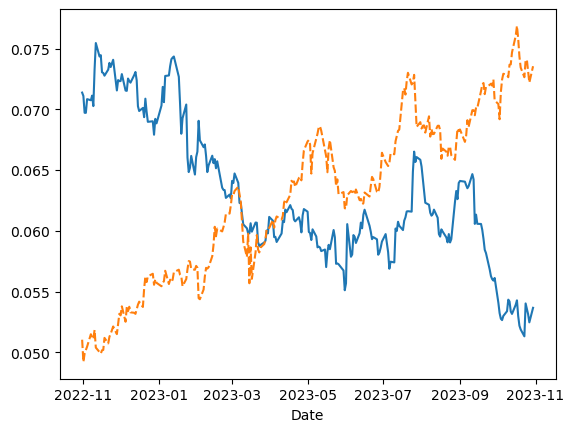

In [9]:
ax, fig = plt.subplots()
sns.lineplot(data = closing_prices_l2[["MMM", "ACGL"]], legend = None)

# Sharpe Normalization

In [10]:
# rate of return:
ROR = closing_prices.pct_change().dropna()

Checking the rate of return for some assets to see what kind of distribution we are dealing with

<AxesSubplot:ylabel='Count'>

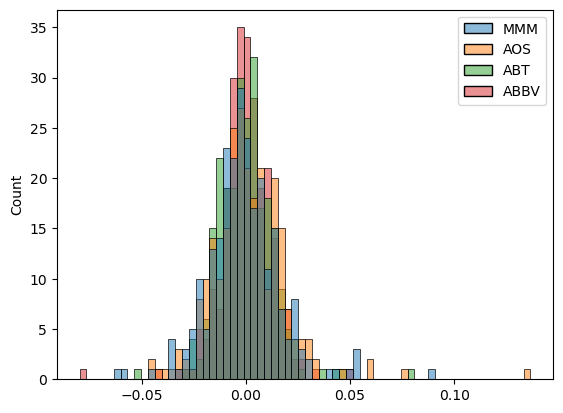

In [11]:
sns.histplot(ROR[ROR.columns[0:4]])

While this is not exactly a normal distribution, the theory says that log(1 + ROR) should be roughly normal, and when returns are small $\log(1+x) \approx x$, so for now, we will just use ROR. To see what functions are doing under the hood, see the preprocessing.py file

In [12]:
from data_processing.preprocessing import risk
from data_processing.preprocessing import sharpe_normalize

sigma = risk(ROR, 10) # this is the risk
sharpe = sharpe_normalize(closing_prices, 10)

<AxesSubplot:xlabel='Date'>

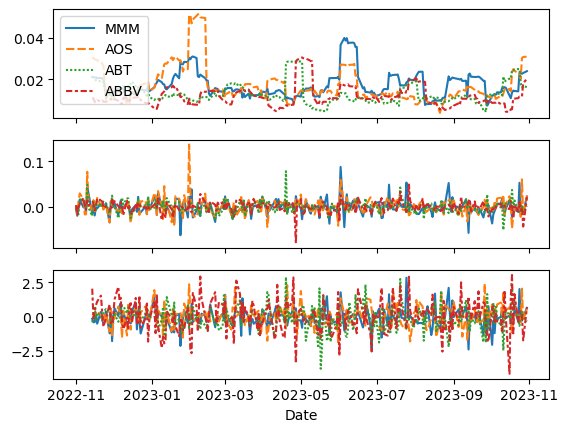

In [13]:
f, axarr = plt.subplots(3, sharex=True)
sns.lineplot(data = sigma[sigma.columns[0:4]], ax = axarr[0])
sns.lineplot(data = ROR[ROR.columns[0:4]], ax = axarr[1], legend = False)
sns.lineplot(data = sharpe[sharpe.columns[0:4]], ax = axarr[2], legend = False)

We do the same correlation analysis that we did for L^2 normalizations

In [14]:
tickers = sharpe.columns
corr_sharpe = np.tril(sharpe.corr().values, -1)
high_corrs_sharpe = np.where((corr_sharpe > 0).astype(int) == 1)
high_corrs_sharpe = list(zip(high_corrs_sharpe[0], high_corrs_sharpe[1]))
high_corrs_sharpe.sort(key = lambda a: -corr_sharpe[a])
# print the top 10 high correlations
for i, j in high_corrs_sharpe[:10]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr_sharpe[i][j]}")
    

Correlation between GOOG and GOOGL is: 0.9963703287251051
Correlation between NWS and NWSA is: 0.9880390113175918
Correlation between FOX and FOXA is: 0.9820022118967948
Correlation between WM and RSG is: 0.9129701665045096
Correlation between EQR and AVB is: 0.9018578656014261
Correlation between VMC and MLM is: 0.901038710833695
Correlation between WEC and CMS is: 0.8982121721301073
Correlation between LRCX and AMAT is: 0.8974999302175776
Correlation between WEC and AEE is: 0.8966283596646346
Correlation between CMS and LNT is: 0.8966012997055772


Amazing! This seems to have found the duplicate stocks a better than the L^2 normalization, but the earlier high correlation between LEN and DHI is gone. I wonder what happened to them...

correlation between LEN and DHI: 0.8886718986277412


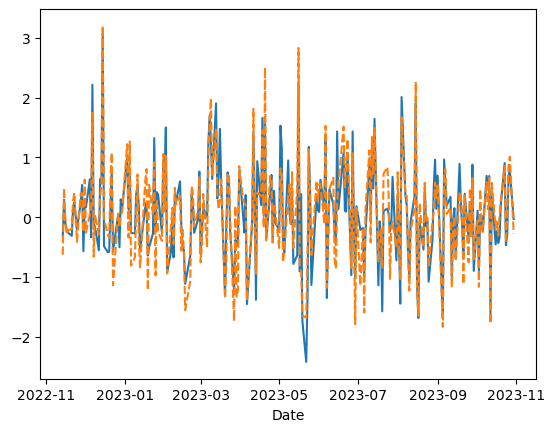

In [15]:
coef = np.corrcoef(sharpe["LEN"].values, sharpe["DHI"].values)
print(f"correlation between LEN and DHI: {coef[1,0]}")
ax = sns.lineplot(data = sharpe[["LEN", "DHI"]], legend = False)

In [16]:
low_corrs_sharpe = np.where((corr_sharpe < -0.2).astype(int) == 1)
low_corrs_sharpe = list(zip(low_corrs_sharpe[0], low_corrs_sharpe[1]))
for i, j in low_corrs_sharpe[:10]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr_sharpe[i][j]}")

Correlation between ADBE and ADM is: -0.21908328015176604
Correlation between AFL and ADBE is: -0.2184617114073009
Correlation between ABNB and ABBV is: -0.31350383215038163
Correlation between ALK and ABBV is: -0.2258998101477405
Correlation between ALK and ADP is: -0.2876583483355402
Correlation between ALB and ABT is: -0.2737849185225574
Correlation between ALB and ABBV is: -0.34696569256062204
Correlation between ARE and APD is: -0.25237026899247333
Correlation between ALGN and ABBV is: -0.22373996812273783
Correlation between ALGN and ADM is: -0.3534044961308667


<AxesSubplot:xlabel='Date'>

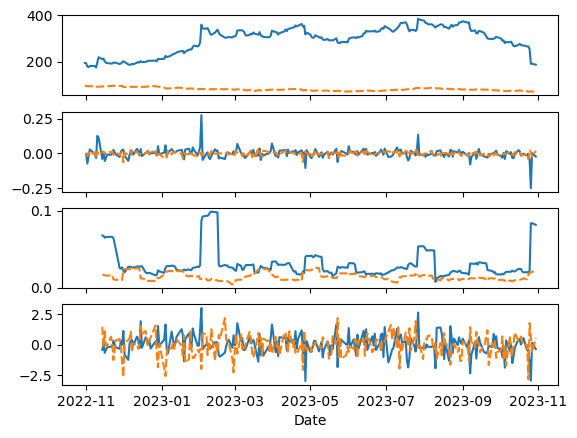

In [17]:
f, axarr = plt.subplots(4, sharex=True)
sns.lineplot(data = closing_prices[["ALGN", "ADM"]], ax = axarr[0], legend = False)
sns.lineplot(data = ROR[["ALGN", "ADM"]], ax = axarr[1], legend = False)
sns.lineplot(data = sigma[["ALGN", "ADM"]], ax = axarr[2], legend = False)
sns.lineplot(data = sharpe[["ALGN", "ADM"]], ax = axarr[3], legend = False)

# Examining Correlation Histograms

It's impractical to look at all of the correlations in a 500x500 matrix. Nevertheless, we can still try to look at the *collection* of correlations to see if there are any equities that look like they *do* move together. We will plot some histograms of correlations

As a baseline model, we can cluster the equities by industry, and see if the correlations have anything to do with the industry of the equity.

We do this for L^2 and for sharpe normalizations.

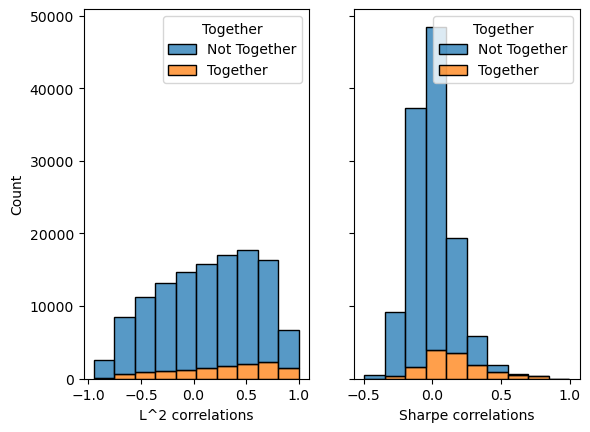

In [18]:
from data_processing.preprocessing import correlation_histogram

from SP500models import industry
# I made a function to do this. See preprocessing for the spaghetti
f, axarr = plt.subplots(1,2, sharey = True)

axarr[0].set_xlabel("L^2 correlations")

axarr[1].set_xlabel("Sharpe correlations")
correlation_histogram(closing_prices_l2, bins = 10, clusters = industry(closing_prices_l2), ax = axarr[0])
correlation_histogram(sharpe, bins = 10, clusters = industry(sharpe), ax = axarr[1])

Interesting to note that the "industry" clusters perform well in the Sharpe normalization, but not so well in the L^2 normalization. Still, there's some things that seem quite correlated but are not in the same industry, and there are some things that are in the same industry but not correlated